In [1]:
# Install Tesseract
!sudo apt install tesseract-ocr -y
!pip install pytesseract Pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
from google.colab import files
from PIL import Image
import io

# Upload image
uploaded = files.upload()

# Load image from uploaded file
image_path = list(uploaded.keys())[0]
image = Image.open(io.BytesIO(uploaded[image_path]))
image.show()

Saving ocrtestimag1.jpg to ocrtestimag1.jpg


In [4]:
import pytesseract

# Run OCR
extracted_text = pytesseract.image_to_string(image)

# Display OCR result
print("🔍 Extracted Text:")
print(extracted_text)

🔍 Extracted Text:
 

 

This is a lof ofl 12 point texd to test the
code) if works types
ofifile format)
quick brown dog jumped oven the
lazy fox! pues be brown dog jumped
over tthe eae g ics brown dog
jumped over the lazy fox! al quick
brown dog jumped tthe lazy fox!

 

 

 

 

 

 

 

 

 

 

 



In [5]:
import re

def clean_ocr_text(text):
    # Remove multiple spaces and newlines
    text = re.sub(r'\n+', '\n', text)                 # collapse multiple newlines
    text = re.sub(r'[ \t]+', ' ', text)               # collapse multiple spaces/tabs
    text = re.sub(r'\s+\n', '\n', text)               # remove trailing space before newline
    text = re.sub(r'\n\s+', '\n', text)               # remove leading space after newline
    text = re.sub(r'[^\x00-\x7F]+', '', text)         # remove non-ASCII characters
    text = text.strip()

    return text

# Clean the extracted text
cleaned_text = clean_ocr_text(extracted_text)

# Display cleaned text
print("🧼 Cleaned Text:")
print(cleaned_text)


🧼 Cleaned Text:
This is a lof ofl 12 point texd to test the
code) if works types
ofifile format)
quick brown dog jumped oven the
lazy fox! pues be brown dog jumped
over tthe eae g ics brown dog
jumped over the lazy fox! al quick
brown dog jumped tthe lazy fox!


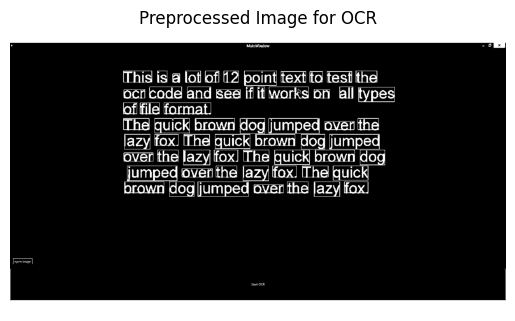

🔍 Improved OCR Result:
y ps ee Gy
nM NRE) texd fo test thd
works Tees
ofifile format
quick brown dog jumped over tthe
lazy fox! (he quick brown dog jumped
late evaupicoyd) quick brown dog
jumped over the |azy/lfox! [hel quick
brown dog jumped aver the |azy fox!


In [6]:
import cv2
import numpy as np

# Convert PIL image to OpenCV format
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Convert to grayscale
gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)

# Apply thresholding (binarization)
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Optional: dilation to make characters more distinct
kernel = np.ones((1, 1), np.uint8)
processed_image = cv2.dilate(thresh, kernel, iterations=1)

# Show processed image
from matplotlib import pyplot as plt
plt.imshow(processed_image, cmap='gray')
plt.title("Preprocessed Image for OCR")
plt.axis('off')
plt.show()

# Convert back to PIL for pytesseract
from PIL import Image
processed_pil = Image.fromarray(cv2.cvtColor(processed_image, cv2.COLOR_GRAY2RGB))

# OCR on the processed image
improved_text = pytesseract.image_to_string(processed_pil)

# Clean it again
cleaned_improved_text = clean_ocr_text(improved_text)

print("🔍 Improved OCR Result:")
print(cleaned_improved_text)


In [7]:
# !pip install easyocr

# import easyocr
# reader = easyocr.Reader(['en'])  # language = English

# # OCR with EasyOCR
# bounds = reader.readtext(np.array(image), detail=0)

# # Join and clean
# easyocr_text = "\n".join(bounds)
# cleaned_easyocr_text = clean_ocr_text(easyocr_text)

# print("🧠 EasyOCR Cleaned Text:")
# print(cleaned_easyocr_text)


In [8]:
!pip install transformers sentencepiece

from transformers import pipeline

# Load summarization pipeline (you can try T5 or BART)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [11]:
# Use improved or easyocr-cleaned text here
text_to_summarize = cleaned_improved_text  # or cleaned_easyocr_text if you used EasyOCR

# Limit input to ~1024 tokens (~4000 chars max for most models)
text_to_summarize = text_to_summarize.strip()[:4000]

# Generate summary
summary = summarizer(text_to_summarize, max_length=80, min_length=30, do_sample=False)

print("📝 Summary:")
print(summary[0]['summary_text'])


📝 Summary:
quick brown dog jumped over tthe                lazy fox! (he quick Brown Dog jumped                late evaupicoyd) quick brown dog                jumped over the |azy/lfox! [hel quick                brown dog jumped aver the | lazy fox!


In [12]:
from huggingface_hub import notebook_login

notebook_login()

In [13]:
import torch
from transformers import pipeline

# Use an instruction-tuned model from Hugging Face
pipe = pipeline(
    "text-generation",
    model="NousResearch/Llama-2-7b-chat-hf",
    device=0 if torch.cuda.is_available() else -1
)

prompt = f"""
You are an AI assistant. The following text was extracted using OCR and contains typos and formatting errors.

Your task is to:
1. Correct any spelling or formatting mistakes.
2. Summarize the corrected text.

OCR Output:
\"\"\"{cleaned_improved_text}\"\"\"

Please return the corrected text first, then the summary.
"""

response = pipe(prompt, max_new_tokens=300, do_sample=False)
print(response[0]['generated_text'])

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



You are an AI assistant. The following text was extracted using OCR and contains typos and formatting errors.

Your task is to:
1. Correct any spelling or formatting mistakes.
2. Summarize the corrected text.

OCR Output:
"""y ps ee Gy
nM NRE) texd fo test thd
works Tees
ofifile format
quick brown dog jumped over tthe
lazy fox! (he quick brown dog jumped
late evaupicoyd) quick brown dog
jumped over the |azy/lfox! [hel quick
brown dog jumped aver the |azy fox!"""

Please return the corrected text first, then the summary.

Thank you!
